#An analysis of Machine Learning models on Covid19 vaccine opinion on Twitter


#TASK I

In [2]:
import numpy as np 
import pandas as pd
import os


In [3]:
traindf=pd.read_csv('/vax_train.csv')
testdf=pd.read_csv('/vax_test.csv')

In [4]:
traindf.head()

,id,tweet,label
0,1329771561671417856,Today Pfizer said it's asking U.S. regulators ...,Neutral
1,1266030447919804420,Good news on development of new #covid19 #vacc...,ProVax
2,1238769307456172034,Once they get a corona vaccine I don’t want to...,ProVax
3,1328814394822705152,Free flu vaccines and COVID-19 tests! https://...,Neutral
4,1254610119876280320,"Bollywood Gupshup,Russian Researchers Will Tes...",ProVax


In [5]:
testdf.head()

,id,tweet
0,1472958183882719233t,So true. Take control of what you can…get vac...
1,1449995880904470529t,The vaccinated still spread it and are factori...
2,1480413964265660416t,"NT records 403 new cases of COVID-19, as it ex..."
3,1408119497962057742t,@ochealth You are experimenting with people. B...
4,1439361704320806915t,@LPCPressBox So I guess we’re supposed to just...


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import transformers
from transformers import AutoTokenizer,TFBertModel

In [ ]:
tf=AutoTokenizer.from_pretrained('bert-large-uncased')
bert=TFBertModel.from_pretrained('bert-large-uncased')

In [8]:
print(max([len(x.split()) for x in traindf['tweet']]))

98


In [9]:
xtrain=tf(
    text=traindf['tweet'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

In [10]:
traindf = traindf.replace(['Neutral'],2)
traindf = traindf.replace(['ProVax'],0)
traindf = traindf.replace(['AntiVax'],1)
traindf.head()

,id,tweet,label
0,1329771561671417856,Today Pfizer said it's asking U.S. regulators ...,2
1,1266030447919804420,Good news on development of new #covid19 #vacc...,0
2,1238769307456172034,Once they get a corona vaccine I don’t want to...,0
3,1328814394822705152,Free flu vaccines and COVID-19 tests! https://...,2
4,1254610119876280320,"Bollywood Gupshup,Russian Researchers Will Tes...",0


In [11]:
ytrain=traindf.label.values
ytrain

array([2, 0, 0, ..., 0, 0, 0])

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.utils import plot_model

In [13]:
max_len = 100
from tensorflow.keras.layers import Input, Dense
input_ids = Input(shape=(max_len,),dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,),dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]
embeddings = bert([input_ids,input_mask])[1] #(0 is the last hidden states, 1 means pooler_output)
# the shape of hidden states is (None,max_len, 1024)
# the shape of pooled output is (None, 1924)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(1,activation = 'sigmoid')(out)

In [14]:
model = tf.keras.Model(inputs=[input_ids, input_mask] ,outputs=y)
model.layers[2].trainable = True

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [17]:
optimizer = Adam(
learning_rate = 5e-06, # this learning rate is for bert model , taken from huggingface website
epsilon=1e-08,
decay=0.01,
clipnorm=1.0)
# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
optimizer = optimizer,
loss = loss,
metrics=metric)

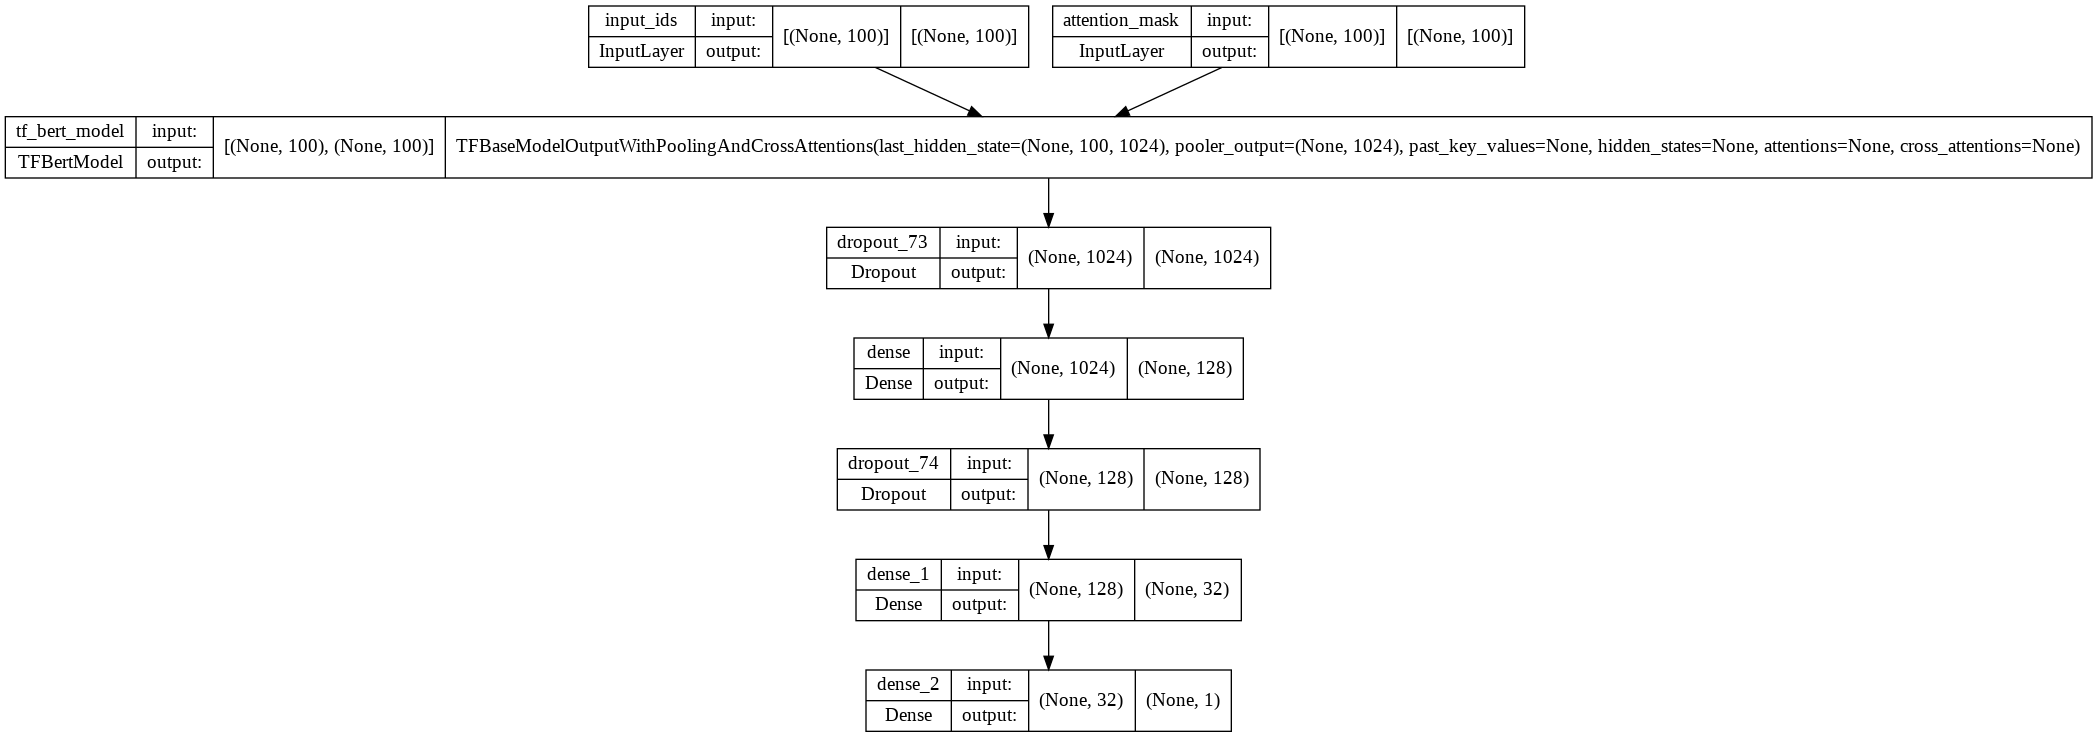

In [18]:
plot_model(model,show_shapes=True)

In [19]:
tf.config.experimental.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

#Training the model

In [ ]:
train_history=model.fit(
x ={'input_ids':xtrain['input_ids'],'attention_mask':xtrain['attention_mask']} ,
y = ytrain,
validation_split = 0.2,
epochs=1,
batch_size=10)

#Testing the model

TASK II